## Mount the bucket, copy it to local Colab

In [3]:
!mkdir -p /content/data

In [4]:
!gsutil -m cp -r gs://mmfood/mmfood100k/v1/* /content/data

Copying gs://mmfood/mmfood100k/v1/candidates.csv...
Copying gs://mmfood/mmfood100k/v1/images/apple/000000.jpg...
Copying gs://mmfood/mmfood100k/v1/labels.csv...
Copying gs://mmfood/mmfood100k/v1/images/apple/000005.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000002.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000003.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000004.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000001.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000006.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000007.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000008.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000009.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000010.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000011.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000012.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple/000013.jpg...
Copying gs://mmfood/mmfood100k/v1/images/apple

In [5]:
pwd

'/content'

In [7]:
cd data/images

/content/data/images


In [8]:
ll

total 112
drwxr-xr-x 2 root 12288 Feb 20 11:33 apple/
drwxr-xr-x 2 root 12288 Feb 20 11:33 boiled_eggs/
drwxr-xr-x 2 root 12288 Feb 20 11:34 egg_tart/
drwxr-xr-x 2 root 12288 Feb 20 11:35 fried_chicken/
drwxr-xr-x 2 root 12288 Feb 20 11:35 grilled_steak/
drwxr-xr-x 2 root  4096 Feb 20 11:36 hamburger/
drwxr-xr-x 2 root 12288 Feb 20 11:36 mapo_tofu/
drwxr-xr-x 2 root 12288 Feb 20 11:37 pizza/
drwxr-xr-x 2 root 12288 Feb 20 11:37 ramen/
drwxr-xr-x 2 root 12288 Feb 20 11:38 sushi/


In [9]:
import os

In [10]:
data_dir = "/content/data/images"

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)

    if os.path.isdir(class_path):
        image_files = [
            f for f in os.listdir(class_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        print(f"{class_name}: {len(image_files)}")

mapo_tofu: 200
ramen: 200
boiled_eggs: 200
hamburger: 184
egg_tart: 200
fried_chicken: 200
apple: 200
sushi: 200
pizza: 200
grilled_steak: 194


## Minimal Preprocessing

### ① Resize → image_size = (224, 224)

In [11]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import tensorflow as tf

In [19]:
image_size=(224, 224)
batch_size=32

In [45]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

Found 1978 files belonging to 10 classes.
Using 1385 files for training.


In [47]:
class_names = train_ds.class_names

In [21]:
val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

Found 1978 files belonging to 10 classes.
Using 593 files for validation.


In [22]:
val_test_batches = tf.data.experimental.cardinality(val_test_ds).numpy()
val_batches = val_test_batches // 2

In [25]:
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

### ② Performance optimization

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

### ③ Confirm data type

In [31]:
for images, labels in train_ds.take(1):
    print(images.dtype)

<dtype: 'float32'>


In [32]:
for images, labels in train_ds.take(1):
    print(labels[:10])

tf.Tensor([2 4 2 7 3 0 3 5 8 3], shape=(10,), dtype=int32)


## Training Model

#### 1️⃣ Building model
Normalize (preprocess_input) + Augment (data_augmentation)

In [33]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base_model.trainable = False

model = tf.keras.Sequential([
    data_augmentation,                # 1️⃣ Augment
    layers.Lambda(preprocess_input),  # 2️⃣ EfficientNet Preprocessing
    base_model,                       # 3️⃣ backbone
    layers.GlobalAveragePooling2D(),
    layers.Dense(10, activation="softmax")
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### 2️⃣ Compile

In [35]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

#### 3️⃣ EarlyStopping

In [36]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

#### 4️⃣ Training

In [37]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.4249 - loss: 1.8276 - val_accuracy: 0.8438 - val_loss: 0.7310
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.8609 - loss: 0.6469 - val_accuracy: 0.8958 - val_loss: 0.4391
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.9200 - loss: 0.3891 - val_accuracy: 0.9167 - val_loss: 0.3420
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.9333 - loss: 0.3135 - val_accuracy: 0.9306 - val_loss: 0.2815
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9434 - loss: 0.2640 - val_accuracy: 0.9306 - val_loss: 0.2566
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9592 - loss: 0.2228 - val_accuracy: 0.9375 - val_loss: 0.2304
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9578 - loss: 0.2047 - val_accuracy: 0.9375 - val_loss: 0.2115
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9603 - loss: 0.1749 - val_accuracy: 0.9444 - v

In [43]:
print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,088,003 (15.59 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 25,622 (100.09 KB)

None


### Evaluate

In [38]:
model.evaluate(test_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9660 - loss: 0.1299


[0.12269654870033264, 0.9704918265342712]

#### Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


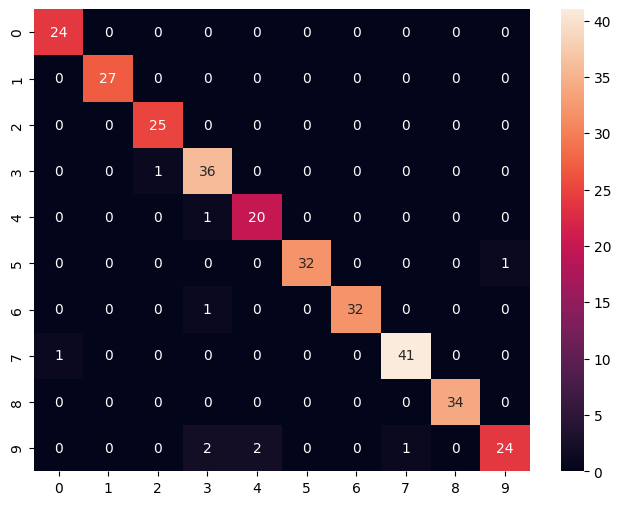

In [40]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

#### accuracy per category

In [49]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

               precision    recall  f1-score   support

        apple       0.96      1.00      0.98        24
  boiled_eggs       1.00      1.00      1.00        27
     egg_tart       0.96      1.00      0.98        25
fried_chicken       0.90      0.97      0.94        37
grilled_steak       0.91      0.95      0.93        21
    hamburger       1.00      0.97      0.98        33
    mapo_tofu       1.00      0.97      0.98        33
        pizza       0.98      0.98      0.98        42
        ramen       1.00      1.00      1.00        34
        sushi       0.96      0.83      0.89        29

     accuracy                           0.97       305
    macro avg       0.97      0.97      0.97       305
 weighted avg       0.97      0.97      0.97       305

